In [20]:
import os
from collections import namedtuple


import pandas as pd
import numpy as np
import duckdb
import polars as pl


Benchmark = namedtuple("Benchmark", )

def get_db_conn():
    results_dir = os.path.abspath('')
    results_db = os.path.join(results_dir, "results.db")
    conn = duckdb.connect(results_db)
    return conn



conn = get_db_conn()

In [40]:
import pprint

bench_id_OS_timer = 6
bench_id_CPU_timer = 5

pp = pprint.PrettyPrinter(indent=4)

# latest benchmark result
def get_bench(conn, bench_id):
    bench_sql = f"""
    select
        id, description, ts_added, frequency_GHz, bench_type, unit
        from benchmark
    where id = '{bench_id}'
    """
    keys = ["id", "description", "ts", "frequency_GHz", "bench_type", "unit"]
    vals = conn.sql(bench_sql).fetchone()
    res = {k:v for (k,v) in zip(keys, vals)}
    return res

def pprint_bench(bench_id):
    bench = get_bench(conn, bench_id)
    pp.pprint(bench)


pprint_bench(bench_id_OS_timer)
pprint_bench(bench_id_CPU_timer)

{   'bench_type': 'total',
    'description': 'OS timer used: for test comparison',
    'frequency_GHz': 2.592224,
    'id': 6,
    'ts': datetime.datetime(2023, 12, 8, 1, 1, 41, 316742),
    'unit': 'ns'}
{   'bench_type': 'total',
    'description': 'CPU timer used: for test comparison',
    'frequency_GHz': 2.592226,
    'id': 5,
    'ts': datetime.datetime(2023, 12, 8, 1, 0, 35, 742483),
    'unit': 'cycles'}


In [70]:
def get_df(conn, bench_id, fn="ijk"):
    res = conn.sql(
        """
        select r.N,
         case when b.unit = 'ns' then r.value
         else (r.value / b.frequency_GHz)
         end as t
        from result r
        join benchmark b on r.bench_id = b.id
        where bench_id = {}
        and fn = '{}'
        order by N asc
        """.format(bench_id, fn)
    )
    return res.df()



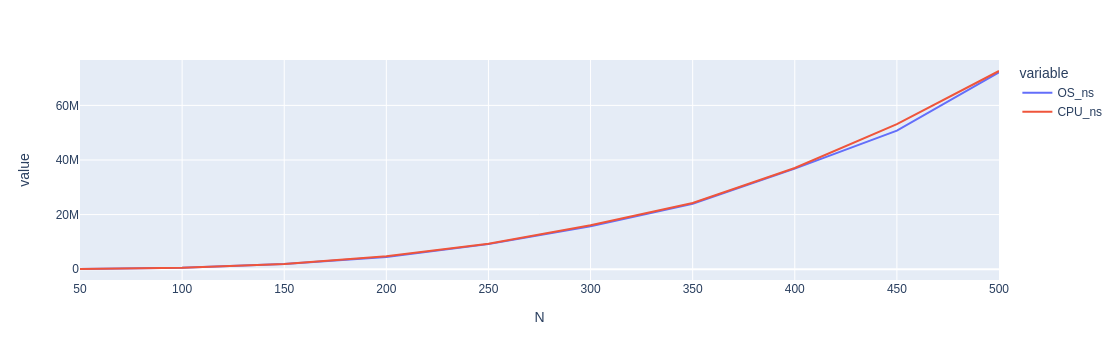

In [80]:
import plotly.express as px 
import pandas as pd

fns = ['jki', 'kji', 'jik', 'ijk', 'kij', 'ikj']
_df = lambda _id: get_df(conn, _id, fns[5])


df = pd.merge(
    _df(bench_id_OS_timer).rename(columns={"t":"OS_ns"}),
    _df(bench_id_CPU_timer).rename(columns={"t": "CPU_ns"}), on="N")
fig = px.line(df, x = 'N', y = ["OS_ns", "CPU_ns"])
fig.show()